In [6]:
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import random

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

/kaggle/input/cat-and-dog/training_set/training_set/dogs/dog.3297.jpg
/kaggle/input/cat-and-dog/training_set/training_set/cats/cat.3203.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4095.jpg
/kaggle/input/cat-and-dog/test_set/test_set/cats/cat.4133.jpg


### Image random examples

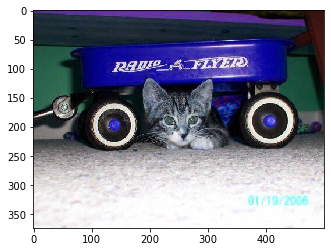

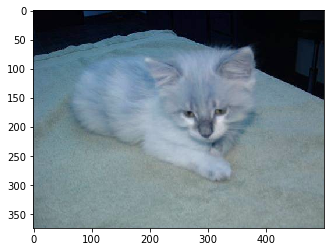

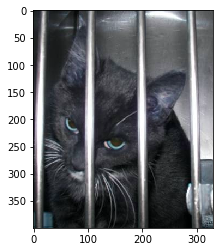

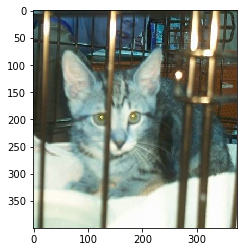

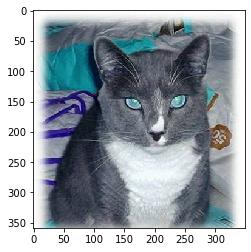

In [7]:
# randomly select 5 images.

CATS_PATH = "../input/cat-and-dog/training_set/training_set/cats/"
cats_images_paths = os.listdir(CATS_PATH)

cats_5_images = random.sample(cats_images_paths, k=5)

for img in cats_5_images:
    cv2_img = cv2.imread(CATS_PATH + img)
    plt.figure()
    plt.imshow(cv2_img)

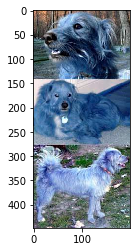

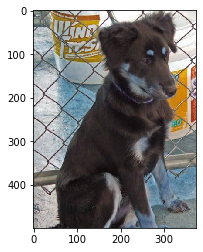

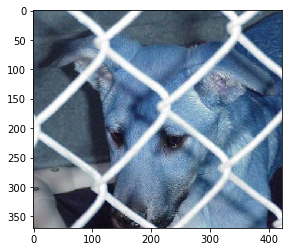

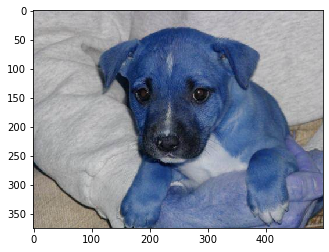

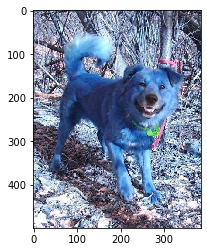

In [8]:
DOGS_PATH = "../input/cat-and-dog/training_set/training_set/dogs/"

dogs_images_paths = os.listdir(DOGS_PATH)

# randomly select 5 images.
dogs_5_images = random.sample(dogs_images_paths, k=5)

for img in dogs_5_images:
    cv2_img = cv2.imread(DOGS_PATH + img)
    plt.figure()
    plt.imshow(cv2_img)

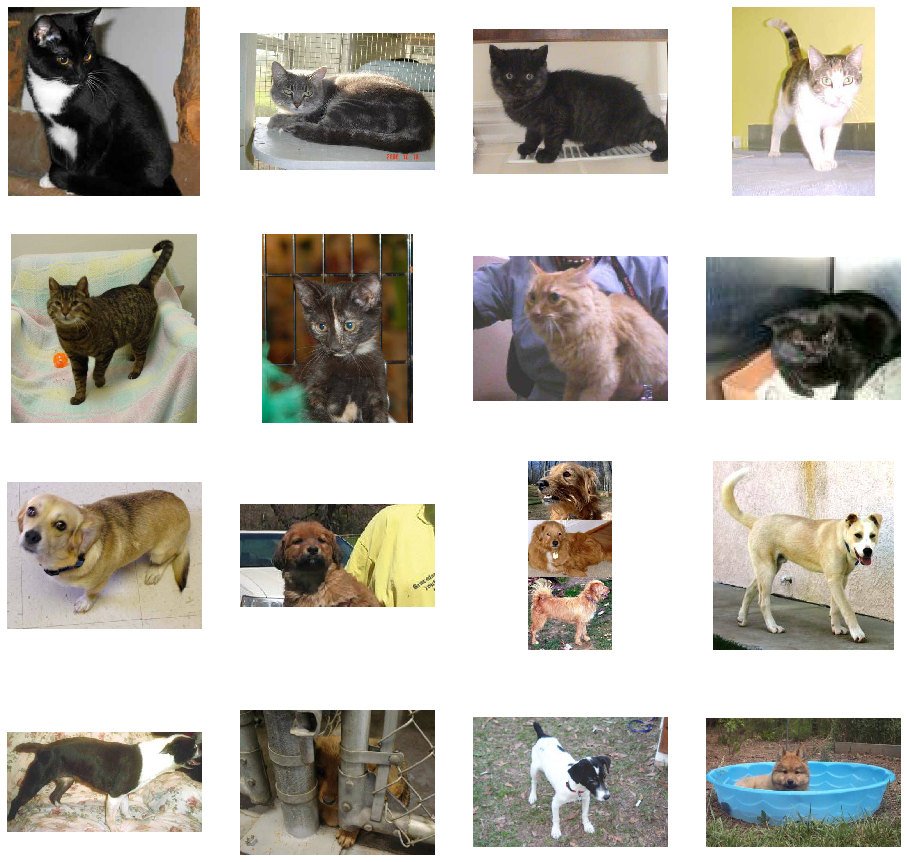

In [9]:
import matplotlib.image as mpimage

train_dir='../input/cat-and-dog/training_set/training_set/'
test_dir='../input/cat-and-dog/test_set/test_set/'

train_cat_dir=train_dir+'cats'
train_dog_dir=train_dir+'dogs'

train_cat_fnames=os.listdir(train_cat_dir)
train_dog_fnames=os.listdir(train_dog_dir)

nrows=4
ncols=4
pic_index=0

fig=plt.gcf()
fig.set_size_inches(nrows*4,ncols*4)

pic_index+=8

next_cat_pix=[os.path.join(train_cat_dir,fname) for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix=[os.path.join(train_dog_dir,fname) for fname in train_dog_fnames[pic_index-8:pic_index]]

for i,img_path in enumerate(next_cat_pix+next_dog_pix):
    sp=plt.subplot(nrows,ncols,i+1)
    sp.axis('off')
    
    img=mpimage.imread(img_path)
    plt.imshow(img)

### Data augmentation

Using ImageDataGenerator we can create new images modifying the existing ones through zooming, flipping, distorting,etc.

In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255, #rescale: 255 pixels per img
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

#Only the train set have data augmentation; we only apply reescaling to the test set
test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('../input/cat-and-dog/training_set', 
                                                    target_size = (64, 64), 
                                                    batch_size = 32, #normaly 32 or 64
                                                   class_mode = 'binary')

test_set = test_datagen.flow_from_directory('../input/cat-and-dog/test_set',
                                                target_size = (64, 64),
                                                 batch_size = 32, 
                                                 class_mode = 'binary')

Using TensorFlow backend.


Found 8005 images belonging to 1 classes.
Found 2023 images belonging to 1 classes.


### CNN Model

* **Layers**: Conv2D, MaxPool2D, Conv2D...Flatten,Dense
* **activation relu**:  introduce nonlinearity to a system that basically has just been computing linear operations during the conv layers. Best than tanh and sigmoid cause computational efficiency
* **Dropout**: drop randomly inputs to avoid overfitting (weight constraint). It can be used after MaxPool layers or Dense layers
* **Flattening**: from tensor to vector
* **Dense**: Full connection layer

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
import keras.backend as K

K.clear_session()

model = Sequential() 
model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu')) #32, 3, 3 --> 32 filters with 3 x 3 for each filter.  # 64, 64, 3 --> 3 color channels (RGB), 64 x 64 pixels.                                                        
model.add(MaxPool2D(pool_size = (2,2))) # 2 x 2 size --> commonly used to keep much information.
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2))) 
model.add(Dropout(0.3))

model.add(Flatten()) #no parameters needed.

model.add(Dense(output_dim = 128, activation = 'relu'))
model.add(Dense(output_dim = 1, activation = 'sigmoid'))

model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1)`


### Training

In [13]:
#fit_generator: used insteat .fit if ImageDataGenerator is used
history = model.fit_generator(training_set,  
                        steps_per_epoch = 100,
                        epochs = 10,
                        verbose = 1,
                        validation_data = test_set, 
                        validation_steps=50)

Epoch 1/10
100/100 [==============================] - 62s 622ms/step - loss: 0.0069 - accuracy: 0.9978 - val_loss: 1.3492e-31 - val_accuracy: 1.0000
Epoch 2/10
100/100 [==============================] - 77s 770ms/step - loss: 7.5761e-14 - accuracy: 1.0000 - val_loss: 3.0661e-23 - val_accuracy: 1.0000
Epoch 3/10
100/100 [==============================] - 47s 474ms/step - loss: 1.8817e-15 - accuracy: 1.0000 - val_loss: 5.9046e-19 - val_accuracy: 1.0000
Epoch 4/10
100/100 [==============================] - 45s 446ms/step - loss: 2.1431e-18 - accuracy: 1.0000 - val_loss: 2.6751e-22 - val_accuracy: 1.0000
Epoch 5/10
100/100 [==============================] - 45s 448ms/step - loss: 5.0466e-16 - accuracy: 1.0000 - val_loss: 1.1128e-26 - val_accuracy: 1.0000
Epoch 6/10
100/100 [==============================] - 49s 494ms/step - loss: 5.8387e-14 - accuracy: 1.0000 - val_loss: 1.6866e-29 - val_accuracy: 1.0000
Epoch 7/10
100/100 [==============================] - 45s 453ms/step - loss: 7.6672e-1

### Evaluation

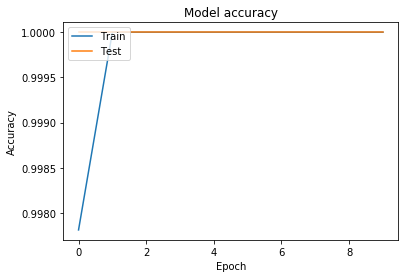

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

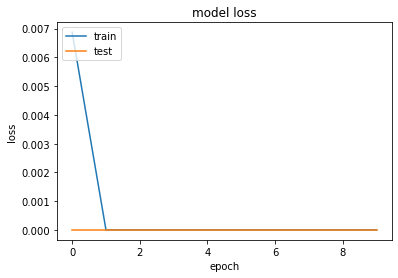

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
#Save model to a file
model.save('cat-dogs-model.h5') 

### How to reduce overfitting in Deep Learning models

* Add more data
* Use data augmentation
* Adding Dropout Layers
* Reduce architecture complexity simplifying the model: remove layers or reduce the number of neurons 

